# FIGS 2H & 3B

*Marcos Martinez Jimenez*

---

Script used to obtain figures 2H and 3B from Networld's PNAS. Basic check that the model retains desirable properties after being modified.

**Input**: processed networld simulation data

## Setup

***Module Import***

In [9]:
import os
import matplotlib.pyplot as plt

from scipy.stats import entropy

from matlab_utils import *

***Global Metadata***

In [3]:
networks, measures = load_meta_networld()

***Data loading***

In [51]:
# Path where all SRC files are included
data_path = '../data/Networld_N40_TMax10000_SimplUnion/'

nt_list = []
for data_file in os.listdir(data_path):
    info = data_file[:-4].split('_')
    if info[0] != 'SRC':
        continue
    beta = info[2][4:]
    rep = info[4][3:]
    data_file = data_path + data_file
    src = load_src_networld(data_file)
    src['beta'] = float(beta)
    src['rep'] = int(rep)
    nt_list.append(src)


For this figures the abundance of networks for each $\beta$ is enough

In [5]:
exp_data = pd.concat(nt_list, axis=0)
exp_data = exp_data.sort_values(by=['beta','rep','NRed'])
exp_data = exp_data.groupby(['beta','NRed'])['NRep'].sum().reset_index()
exp_data['NRep'] = exp_data['NRep'] / exp_data.groupby('beta')['NRep'].transform(sum)
exp_data.head()

,beta,NRed,NRep
0,0.0,0.0,1.000000
1,0.5,0.0,0.794160
2,0.5,1.0,0.183416
3,0.5,2.0,0.018830
4,0.5,4.0,0.000255


## Compute metrics

***# Configurations***

In [6]:
# Number of different network identifiers by beta
num_configs = exp_data.groupby('beta')['NRed'].nunique().reset_index()
num_configs.head()

,beta,NRed
0,0.0,1
1,0.5,20
2,1.0,48
3,1.5,83
4,2.0,169


***Normalized H***

In [7]:
normH = exp_data.groupby('beta')['NRep'].aggregate(entropy).reset_index()
normH['NRep'] = normH['NRep'] / np.log2(num_configs['NRed'])
# For beta=0 only one network -> NA value, but should be a 0
normH = normH.fillna(0)
normH.head()

,beta,NRep
0,0.0,0.000000
1,0.5,0.137290
2,1.0,0.167215
3,1.5,0.188051
4,2.0,0.190340


## Transition Limits

Inspect the graphs to identify prospective transition bounds

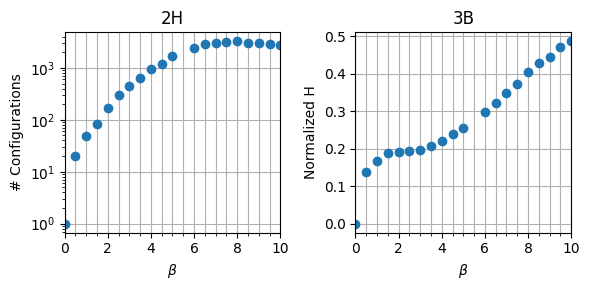

In [8]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(6,3))

ax1.plot(num_configs['beta'], num_configs['NRed'], 'o')
ax1.set_title('2H')
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel('# Configurations')
ax1.set_yscale('log')
ax1.set_xlim(0,10)
ax1.set_xticks(np.arange(0,10.1,0.5), minor=True)
ax1.grid(which='both', axis='x')
ax1.grid(which='major', axis='y')

ax2.plot(normH['beta'], normH['NRep'], 'o')
ax2.set_title('3B')
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel('Normalized H')
ax2.set_xlim(0,10)
ax2.set_xticks(np.arange(0,10.1,0.5), minor=True)
ax2.grid(which='both', axis='x')
ax2.grid(which='major', axis='y')

fig.tight_layout()

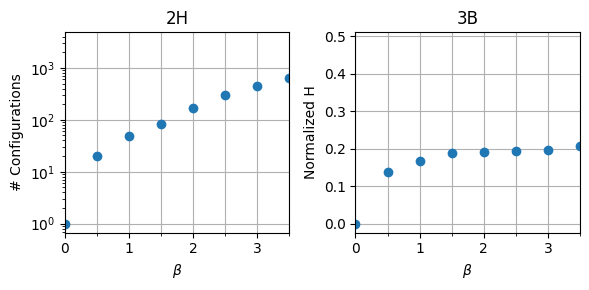

In [10]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(6,3))

ax1.plot(num_configs['beta'], num_configs['NRed'], 'o')
ax1.set_title('2H')
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel('# Configurations')
ax1.set_yscale('log')
ax1.set_xlim(0,3.5)
ax1.set_xticks(np.arange(0,3.6,0.5), minor=True)
ax1.grid(which='both', axis='x')
ax1.grid(which='major', axis='y')

ax2.plot(normH['beta'], normH['NRep'], 'o')
ax2.set_title('3B')
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel('Normalized H')
ax2.set_xlim(0,3.5)
ax2.set_xticks(np.arange(0,3.6,0.5), minor=True)
ax2.grid(which='both', axis='x')
ax2.grid(which='major', axis='y')

fig.tight_layout()

***Transition Bounds***

In [8]:
# 1st value is critic beta and 2nd is the change of behaviour 
# caused by network colapse and node limitation
beta_lims = (1.6,2.5)

In [9]:
pre_idx = num_configs['beta'] < beta_lims[0]
pos_idx = (num_configs['beta'] >= beta_lims[0]) \
    & (num_configs['beta'] < beta_lims[1])

p_nc_pre = np.polyfit(num_configs.loc[pre_idx,'beta'], 
                      np.log(num_configs.loc[pre_idx, 'NRed']), 1)
p_nc_pos = np.polyfit(num_configs.loc[pos_idx,'beta'], 
                      np.log(num_configs.loc[pos_idx, 'NRed']), 1)
p_nH_pre = np.polyfit(normH.loc[pre_idx,'beta'], 
                      normH.loc[pre_idx, 'NRep'], 1)
p_nH_pos = np.polyfit(normH.loc[pos_idx,'beta'], 
                      normH.loc[pos_idx, 'NRep'], 1)

In [10]:
pre_beta_lr = np.array([0.01, beta_lims[0]+0.2])
pos_beta_lr = np.array([beta_lims[0]-0.2, beta_lims[1]+0.2])

pre_nc_lr = np.exp(pre_beta_lr * p_nc_pre[0] + p_nc_pre[1])
pos_nc_lr = np.exp(pos_beta_lr * p_nc_pos[0] + p_nc_pos[1])

pre_nH_lr = pre_beta_lr * p_nH_pre[0] + p_nH_pre[1]
pos_nH_lr = pos_beta_lr * p_nH_pos[0] + p_nH_pos[1]

nc_lr_intersect = (p_nc_pre[1] - p_nc_pos[1]) / (p_nc_pos[0] - p_nc_pre[0])
nH_lr_intersect = (p_nH_pre[1] - p_nH_pos[1]) / (p_nH_pos[0] - p_nH_pre[0])


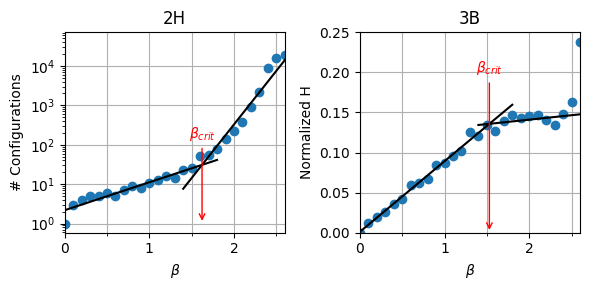

In [16]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(6,3))

ax1.plot(num_configs['beta'], num_configs['NRed'], 'o')
ax1.plot(pre_beta_lr, pre_nc_lr, '-', color='black')
ax1.plot(pos_beta_lr, pos_nc_lr, '-', color='black')
ax1.annotate(r'$\beta_{crit}$', xy=(nc_lr_intersect, 1), 
             xytext=(nc_lr_intersect, 150),
             horizontalalignment='center',
             color='red',
             arrowprops=dict(color='red', arrowstyle='->', lw=1))
ax1.set_title('2H')
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel('# Configurations')
ax1.set_yscale('log')
ax1.set_xlim(0,2.6)
ax1.set_xticks(np.arange(0,2.7,0.5), minor=True)
ax1.grid(which='both', axis='x')
ax1.grid(which='major', axis='y')

ax2.plot(normH['beta'], normH['NRep'], 'o')
ax2.plot(pre_beta_lr, pre_nH_lr, '-', color='black')
ax2.plot(pos_beta_lr, pos_nH_lr, '-', color='black')
ax2.annotate(r'$\beta_{crit}$', xy=(nH_lr_intersect, 0), 
             xytext=(nH_lr_intersect, 0.2),
             horizontalalignment='center',
             color='red',
             arrowprops=dict(color='red', arrowstyle='->', lw=1))
ax2.set_title('3B')
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel('Normalized H')
ax2.set_xlim(0,2.6)
ax2.set_ylim(0,0.25)
ax2.set_xticks(np.arange(0,2.7,0.5), minor=True)
ax2.grid(which='both', axis='x')
ax2.grid(which='major', axis='y')

fig.tight_layout()

In [52]:
tmp_data = pd.concat(nt_list, axis=0)
tmp_data = tmp_data.sort_values(by=['beta','rep','NRed'])
tmp_data = tmp_data.groupby(['beta','rep','t'])['NRep'].sum().reset_index()
tmp_data = tmp_data.groupby(['beta'])['NRep'].mean().reset_index()
tmp_data.head(20)

,beta,NRep
0,0.0,40.000000
1,0.1,39.884322
2,0.2,39.736926
3,0.3,39.568138
4,0.4,39.362214
5,0.5,39.106284
6,0.6,38.791666
7,0.7,38.421608
8,0.8,37.969178
9,0.9,37.459184


<Figure size 600x400 with 0 Axes>

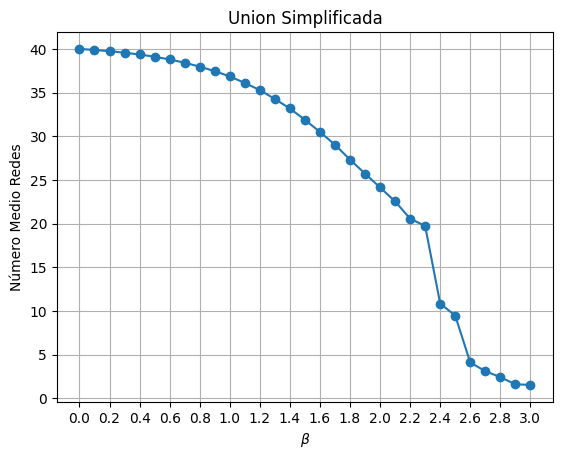

In [56]:
plt.figure(figsize=(6,4))
tmp_data.plot(x='beta',y='NRep', style='-o',legend=False)
plt.xlabel(r'$\beta$')
plt.ylabel('Número Medio Redes')
plt.title('Union Simplificada')
plt.xticks(np.arange(0,3.1,0.2))
plt.grid(which='both')
